In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import re

import os
import glob
import pdb

import matplotlib
from matplotlib import rc
from matplotlib import pyplot as plt
from cycler import cycler

from collections.abc import Mapping, Sequence

import json
import yaml


from dataclasses import dataclass, asdict

import tqdm

import IPython
from IPython.display import display

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# hueristic way to navigate one folder above the notebooks directory
if 'notebooks' in os.getcwd():
    os.chdir('..')

from src import Config

# general utils

In [3]:
def read_experiments(experiment_names, index_field='epoch', only_done=False):
    experiment_names = [os.path.join('results', ename) for ename in experiment_names]
    paths_to_plot = [os.path.join(ename, fname) for ename in experiment_names 
                     for fname in os.listdir(ename) if not ('.yaml' in fname or '.sh' in fname)] 
    short_names = paths_to_plot
    
    eval_dfs = {}
    configs = {}
    for folder_name, short_name in tqdm.tqdm(list(zip(paths_to_plot, short_names))):
        is_done = os.path.exists(os.path.join(folder_name, 'done'))
            
        eval_path = os.path.join(folder_name, 'stats.csv')
        try:
            df = pd.read_csv(eval_path)
        except:
            continue
        
        with open(os.path.join(folder_name, 'config.yaml'), 'r') as f:
            configs[short_name] = asdict(Config(**yaml.safe_load(f)))
    #     df['name'] = short_name
        configs[short_name]['is_done'] = is_done
        
        df = df.rename(columns={'Unnamed: 0': 'epoch'})
        df['epoch'] += 1
        df['step'] = df['train/seen_examples'] / configs[short_name]['batch_size']
        
        df = df.set_index(index_field)
        eval_dfs[short_name] = df

    print('Successfully read %d out of %d folders' % (len(eval_dfs) ,len(paths_to_plot)))

    keys = set([c for df in eval_dfs.values() for c in df.columns]) 

    # turn every run into a "row" in a dataframe that also contains the entire config
    big_df = pd.DataFrame(configs).T.rename_axis('name').sort_index()
    for key in keys:
        big_df[key] = [eval_dfs[name][key] if key in eval_dfs[name].columns else [] for name in big_df.index]
        
    if only_done:
        big_df = big_df[big_df.is_done]
        print('%d results left after filtering' % (len(big_df),))
    
    return big_df

@dataclass
class Interval:
    start: float = -np.inf
    end: float = np.inf

def filt(df, **kwargs):
    filt_df = df.copy()
    for k, v in kwargs.items():
        if callable(v):
            filt_df = filt_df.loc[filt_df[k].apply(v)]
        elif isinstance(v, str):
            if v.startswith('~'):
                filt_df = filt_df.loc[~filt_df[k].str.contains(v[1:])]
            else:
                filt_df = filt_df.loc[filt_df[k].str.contains(v)]
        elif isinstance(v, tuple):
            for vv in v:
                filt_df = filt(filt_df, **{k: vv})
        elif isinstance(v, list):
            filt_df = pd.concat([filt(filt_df, **{k: vv}) for vv in v], axis=0)
        elif isinstance(v, float) or isinstance(v, int) or isinstance(v, bool):
            filt_df = filt_df.loc[filt_df[k]==v]
        elif isinstance(v, Interval):
            filt_df = filt_df[(v.start <= filt_df[k]) & (filt_df[k] <= v.end)]
        else:
          raise ValueError(f'Don''t know how to handle filter type {type(v)}')
    return filt_df

def nanfloat(x):
    try:
        return float(x)
    except:
        return np.nan
    
def nice_string(s):
    return s.replace('_', ' ').capitalize()

def short_string(s, strlen=12):
    return '_'.join([ss[:strlen] for ss in s.split('_')])

def float_fmt(s):
    if isinstance(s, float):
        return f'{s:.4g}'
    else:
        return s

def config_str(ks, vs, key_len=12, sep=', '):
    if not isinstance(vs, (Sequence, np.ndarray)):
        vs = [vs]
    return sep.join([f'{short_string(k, strlen=key_len)} = {float_fmt(v)}' for k, v in zip(ks, vs)])

MARKERS = ['o', 'v', 'p', 'X', '<', 's', '^','P', '*', '>', 'd']
LINESTYLES = ['-', '--', ':', '-.']
COLORS = [c for c in matplotlib.colors.TABLEAU_COLORS]#[:-2]

def get_marker(i):
    return MARKERS[i % len(MARKERS)]

def get_color(i, clist=None):
    if clist is None:
        clist = COLORS
    return clist[i % len(clist)]

def get_linestyle(i):
    return LINESTYLES[i % len(LINESTYLES)]

# Download 

In [4]:
# run this for working with results on local machine. on mac, you need to update rsync with homebrew for the --info=progress2 option to work; on windows, you might need to buy a mac
! rsync -ru --info=progress2 --include='**/stats.csv'  --include='**/*.yaml'  --include='**/done' --include='*/' --exclude='*' \
        $USER@c-001.cs.tau.ac.il:/home/ycarmon/no_backup/users/$USER/experiment-starter/results/ results/

        727,945  33%   99.69kB/s    0:00:07 (xfr#441, to-chk=0/1670)  


# Plot learning curves

In [5]:
big_df = read_experiments(['23-01-10-linear-classifier-example',
                           '23-01-10-linear-classifier-example-2'
                          ], index_field='train/seen_examples')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:05<00:00, 43.49it/s]


Successfully read 216 out of 218 folders


In [6]:
best_loss = big_df.filter(regex='traineval/.*/loss').applymap(min).values.min()
big_df['traineval/last/empirical_subopt'] = big_df['traineval/last/loss'] - best_loss
big_df['traineval/av/empirical_subopt'] = big_df['traineval/last/loss'] - best_loss
big_df['effective_lr'] = big_df.base_lr / (1 - big_df.momentum)

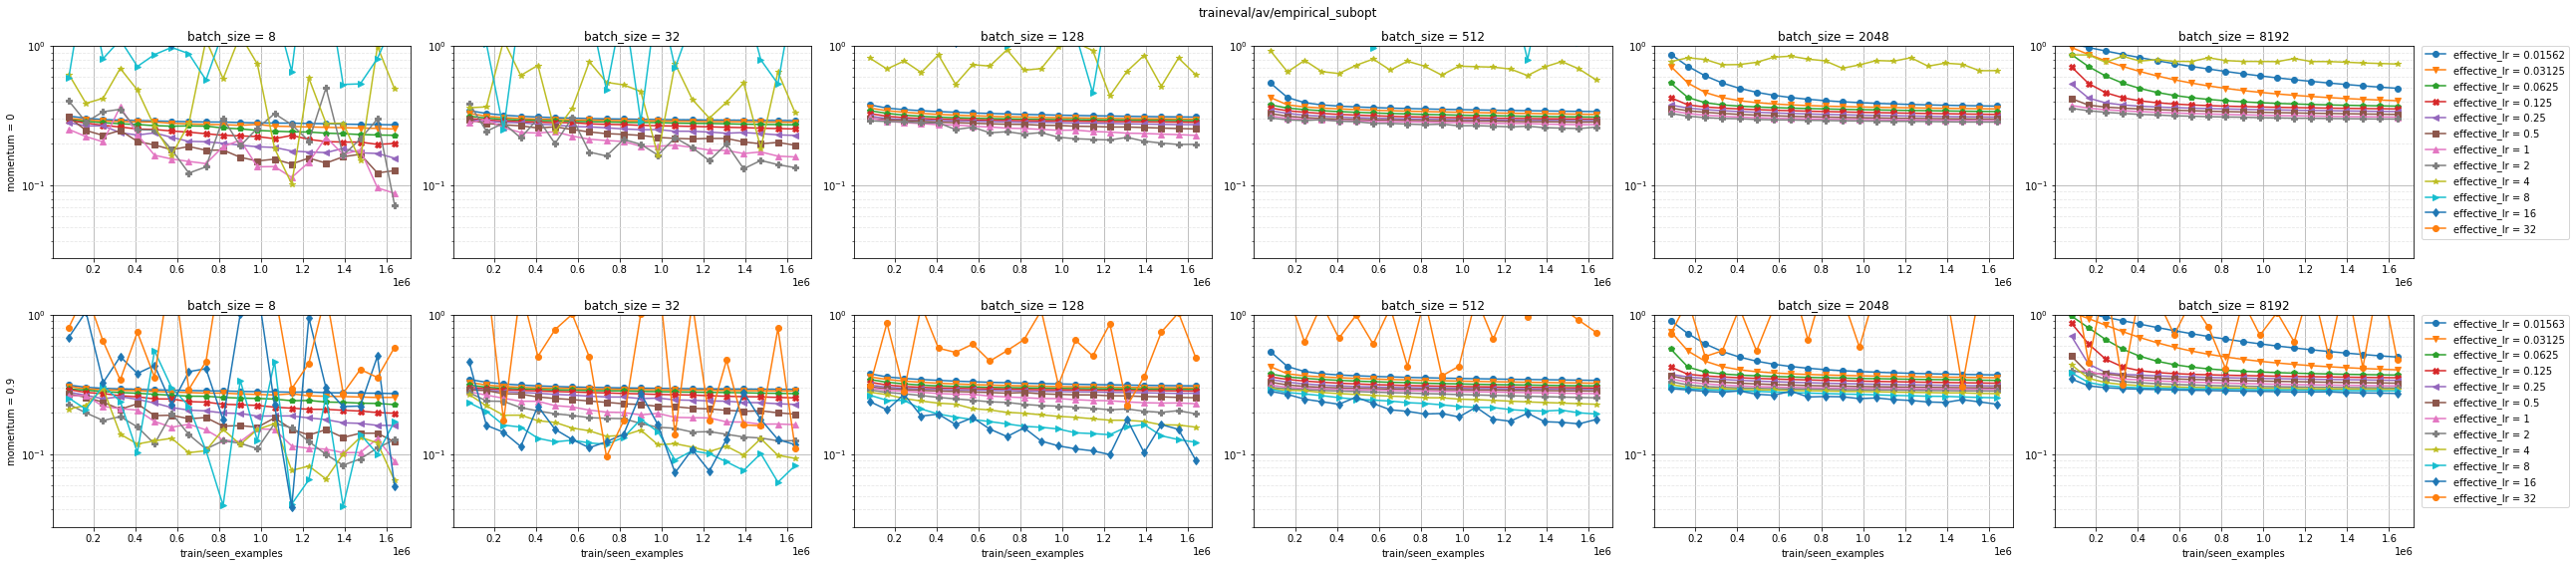

In [7]:
row_fields = ['momentum']
col_fields = ['batch_size']
legend_fields = ['effective_lr']
y_field = 'traineval/av/empirical_subopt'

big_df = big_df.sort_values(row_fields + col_fields + legend_fields)
n_rows = np.vstack(set(map(tuple, big_df[row_fields].values))).shape[0]
n_cols = np.vstack(set(map(tuple, big_df[col_fields].values))).shape[0]

base_size = (6,4)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(base_size[0] * n_cols, base_size[1] * n_rows), facecolor='w')
if n_rows * n_cols == 1:
    axes = np.array(axes)
axes = axes.reshape(n_rows, n_cols)

for i_row, (row_vals, row_df) in enumerate(big_df.groupby(row_fields)):
    for i_col, (col_vals, row_col_df) in enumerate(row_df.groupby(col_fields)):
        plt.sca(axes[i_row, i_col])
        for i_entry, (legend_vals, entry_df) in enumerate(row_col_df.groupby(legend_fields)):
            # we average over repeated entries with the same legend key; a better thing would be to add error bars / shaded region
            plt.plot(sum(entry_df[y_field]) / len(entry_df[y_field]), color=get_color(i_entry), marker=get_marker(i_entry), label=config_str(legend_fields, legend_vals))
        if i_col == 0:
            plt.ylabel(config_str(row_fields, row_vals))
        if i_col == n_cols - 1:  # assuming elements in the plot are the same for every row
            plt.legend(loc='upper left', bbox_to_anchor=[1.01, 1.025])
        if i_row == n_rows - 1:
            plt.xlabel(entry_df.iloc[0][y_field].index.name)
        if 'subopt' in y_field:
            plt.yscale('log')
            plt.ylim([0.03, 1.0])
        if 'accuracy' in y_field:
            plt.ylim([0.4, 0.7])
        
        plt.grid(True, which='major', axis='y')
        plt.grid(True, which='major', axis='x')
        plt.grid(True, which='minor', axis='y', color=[0.9, 0.9, 0.9], linestyle='--')
        plt.title(config_str(col_fields, col_vals))

fig.suptitle(y_field)
plt.tight_layout()
plt.show()           